In [11]:
import cycledata as cd
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.arima_process
import statsmodels.graphics.tsaplots
import seaborn as sns

# matplotlib.style.use('ggplot')
np.random.seed(sum(map(ord, "distributions")))

%matplotlib inline

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=48)
    rolstd = pd.rolling_std(timeseries, window=48)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(16,12))
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.ix[:,0], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)



In [4]:
# Import Full Years (non-seperated weeks)
FullYear = {}
FullYear = cd.Import('fullyear')

Reading 2012FullYear.csv
Reading 2013FullYear.csv
Reading 2014FullYear.csv
Reading 2015FullYear.csv
Reading 2016FullYear.csv


In [5]:
# 4 week section of 2015 to be used for modelling
DF = FullYear['2015']
DF.set_index(DF.s_date, drop=True, inplace=True)
DF = DF['10-2015':'22-12-2015']
DF.dropna()
# Find nearest Sunday
j = 1
while(int(DF[-j:(len(DF) - j + 1)].index.dayofweek) != 6):
    j += 1
# Take last 4 weeks
lastW = int(DF[-j:(len(DF) - j + 1)].index.dayofyear)
firstW = lastW - 28
row = (DF.index.dayofyear > firstW) & (DF.index.dayofyear < (lastW + 1)) 
recent = DF.loc[row, :]

Weekdays and Weekends seperated
Weekdays and Weekends seperated


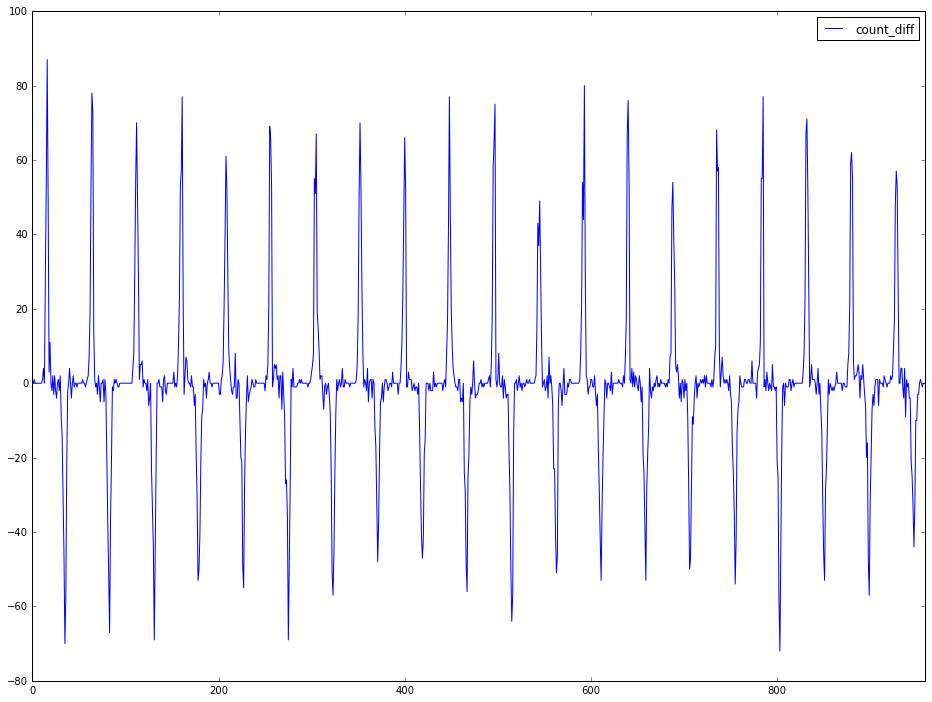

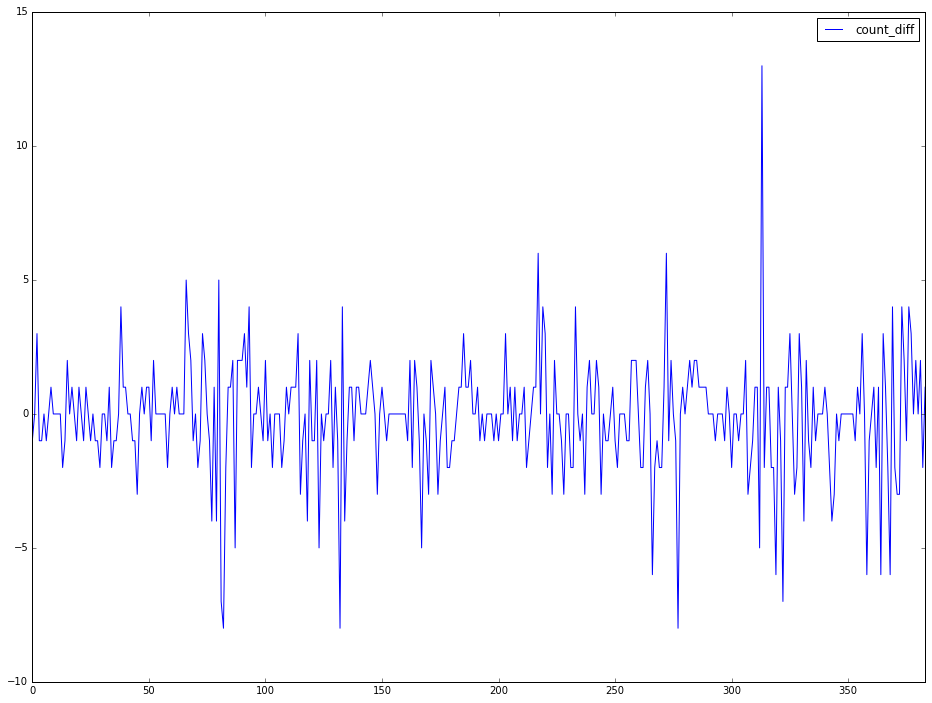

In [6]:
# Model subset of data for particular station
SepModel = cd.Model(recent, 14)
SepModel.PreProcess(seperate=True)
startWD = SepModel.WD.index[0]
startWE = SepModel.WE.index[0]
endWD = SepModel.WD.index[-1]
endWE = SepModel.WE.index[-1]
SepModel.WD.reset_index(inplace=True, drop=True)
SepModel.WE.reset_index(inplace=True, drop=True)
SepModel.WD.plot(figsize=(16,12))
SepModel.WE.plot(figsize=(16,12))
# WDintervals.to_csv(cd.wd + '\\14_WDintervals.csv', index=False)
# WEintervals.to_csv(cd.wd + '\\14_WEintervals.csv', index=False)

C:\Users\George Boss\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


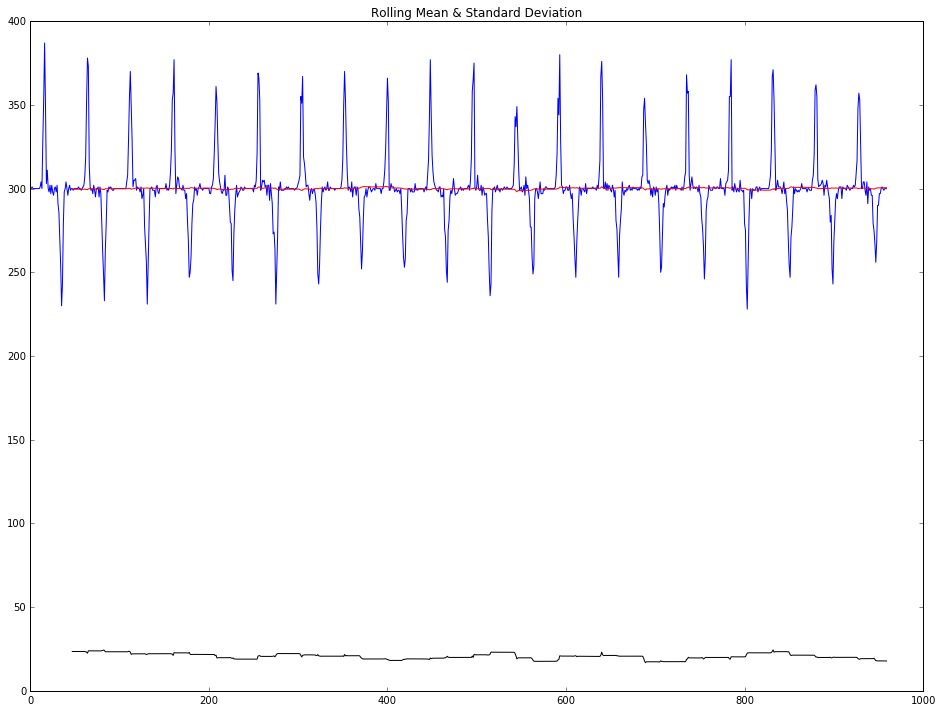

Results of Dickey-Fuller Test:
Test Statistic                -9.153673e+00
p-value                        2.644857e-15
#Lags Used                     1.900000e+01
Number of Observations Used    9.400000e+02
Critical Value (10%)          -2.568410e+00
Critical Value (1%)           -3.437326e+00
Critical Value (5%)           -2.864620e+00
dtype: float64


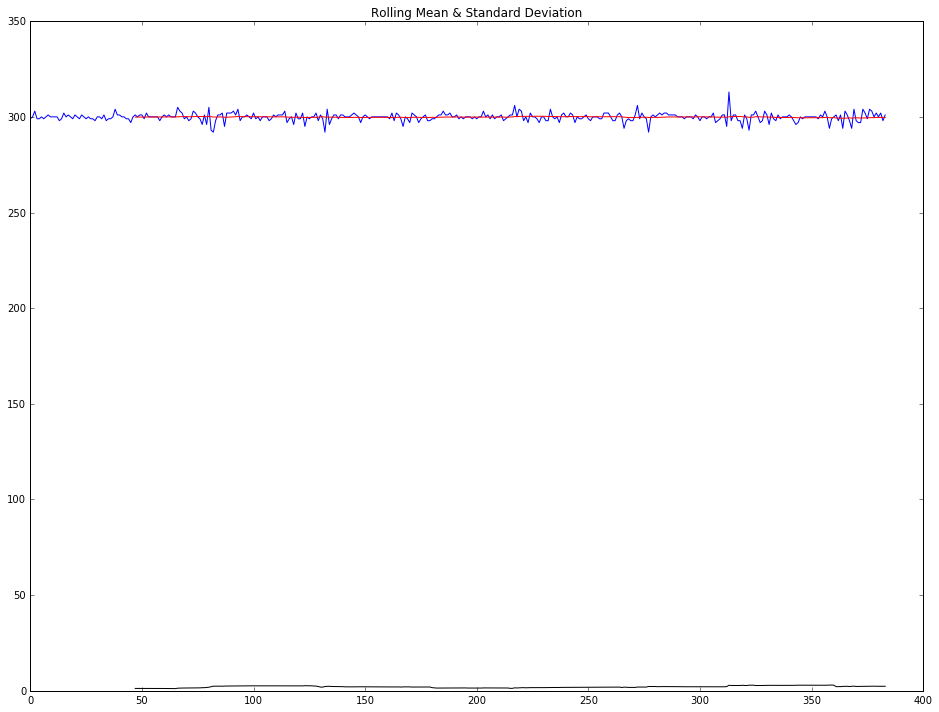

Results of Dickey-Fuller Test:
Test Statistic                 -20.401180
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    383.000000
Critical Value (10%)            -2.570806
Critical Value (1%)             -3.447540
Critical Value (5%)             -2.869116
dtype: float64


In [23]:
test_stationarity(SepModel.WD)
test_stationarity(SepModel.WE)

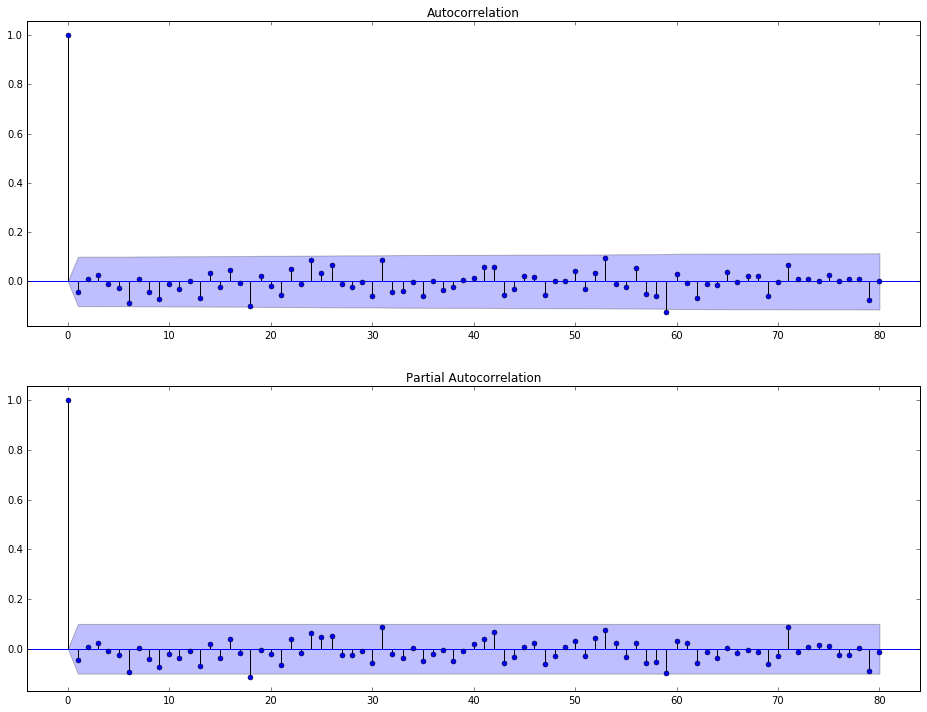

In [24]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(211)
fig = statsmodels.graphics.tsaplots.plot_acf(SepModel.WE, lags=80, ax=ax1)
ax2 = fig.add_subplot(212)
fig = statsmodels.graphics.tsaplots.plot_pacf(SepModel.WE, lags=80, ax=ax2)

NameError: name 'SepModel' is not defined

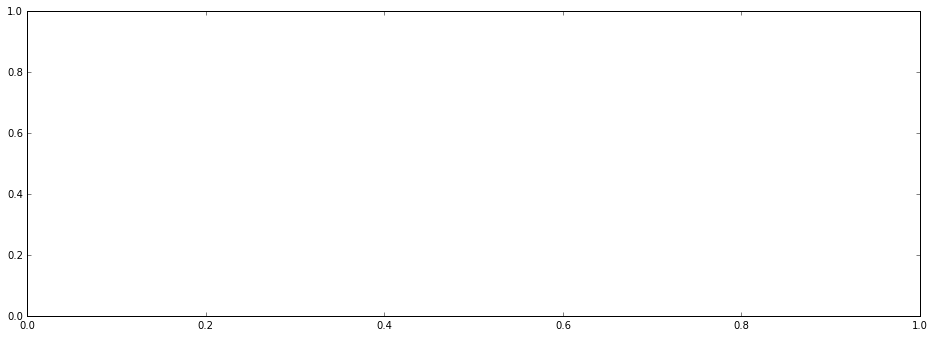

In [3]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(211)
fig = statsmodels.graphics.tsaplots.plot_acf(SepModel.WD, lags=48*4, ax=ax1)
ax2 = fig.add_subplot(212)
fig = statsmodels.graphics.tsaplots.plot_pacf(SepModel.WD, lags=48*4, ax=ax2)

C:\Users\George Boss\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=48).mean()
C:\Users\George Boss\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=48).std()
C:\Users\George Boss\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


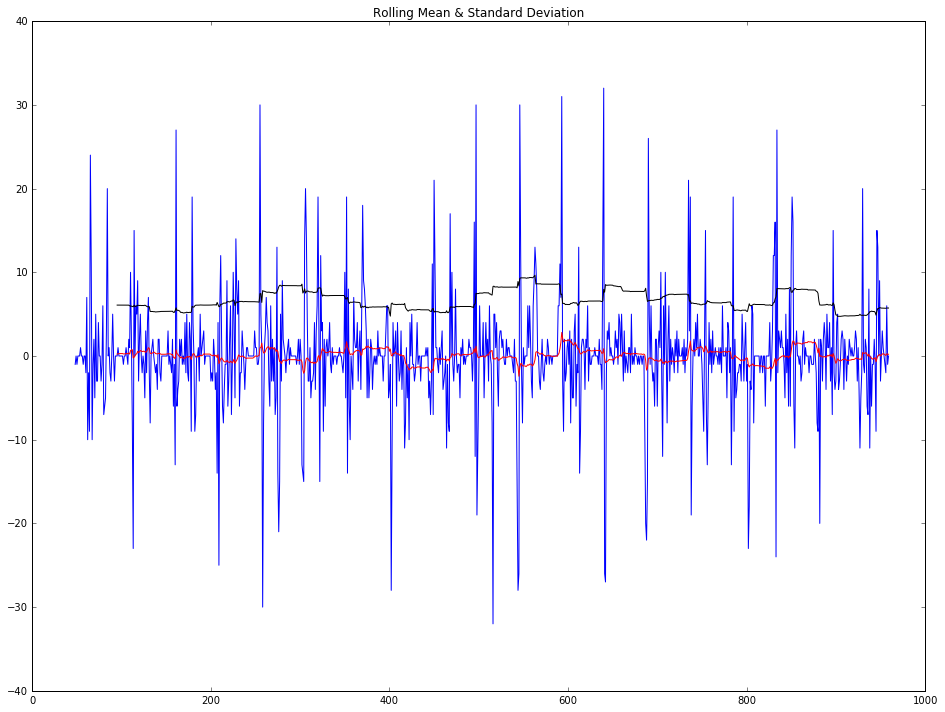

Results of Dickey-Fuller Test:
Test Statistic                -1.754406e+01
p-value                        4.174872e-30
#Lags Used                     3.000000e+00
Number of Observations Used    9.080000e+02
Critical Value (10%)          -2.568468e+00
Critical Value (1%)           -3.437572e+00
Critical Value (5%)           -2.864728e+00
dtype: float64


In [7]:
WDseasDiff = pd.DataFrame(SepModel.WD.count_diff - SepModel.WD.count_diff.shift(48))
test_stationarity(WDseasDiff.dropna(inplace=False))

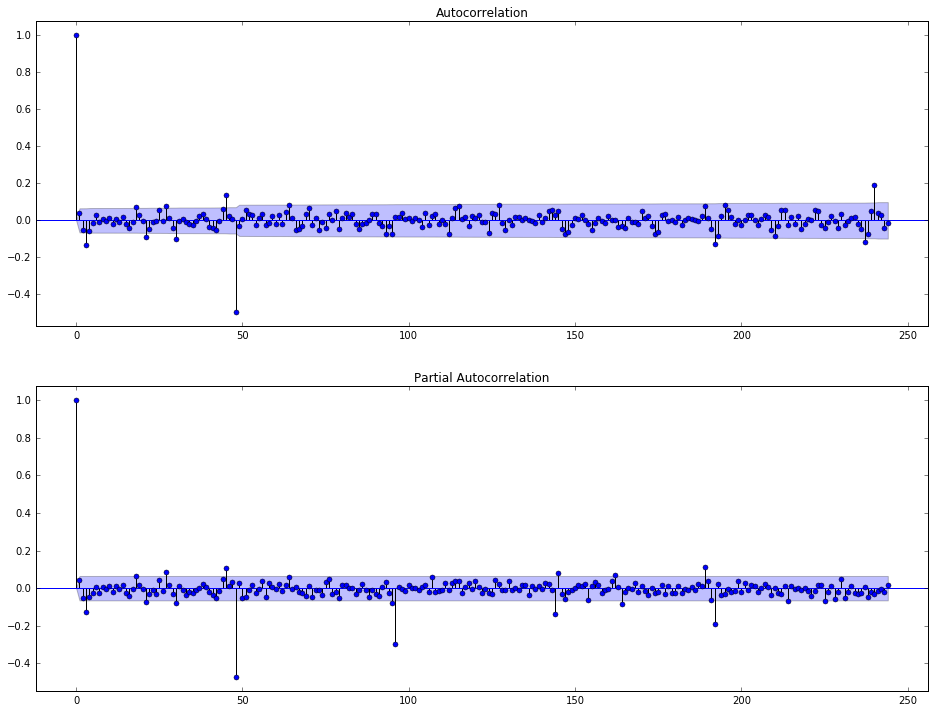

In [10]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(211)
fig = statsmodels.graphics.tsaplots.plot_acf(WDseasDiff[49:], lags=48*5+4, ax=ax1)
ax2 = fig.add_subplot(212)
fig = statsmodels.graphics.tsaplots.plot_pacf(WDseasDiff[49:], lags=48*5+4, ax=ax2)

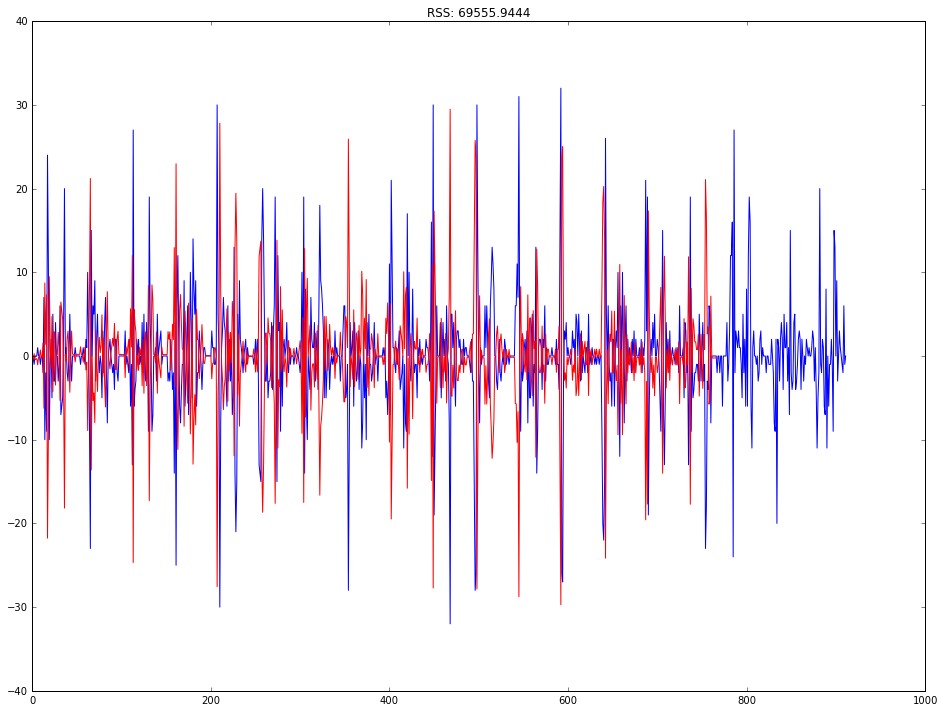

In [75]:
pred_len = 3*48
train = WDseasDiff[0:len(WDseasDiff)-pred_len].dropna(inplace=False)
test = WDseasDiff[len(WDseasDiff)-pred_len:len(WDseasDiff)]
WDseasDiffplot = WDseasDiff.dropna(inplace=False).reset_index(drop=True)


# Best results thus far Seasonal Decomposition->ARIMA (0,1,2) on residuals
model = ARIMA(train.count_diff.values, order=(0, 1, 2))  
results_MA = model.fit(disp=-1) 
plt.figure(figsize=(16,12))
plt.plot(WDseasDiffplot)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-train.count_diff.values[1:])**2)) 
# Residual sum of Squares (RSS)

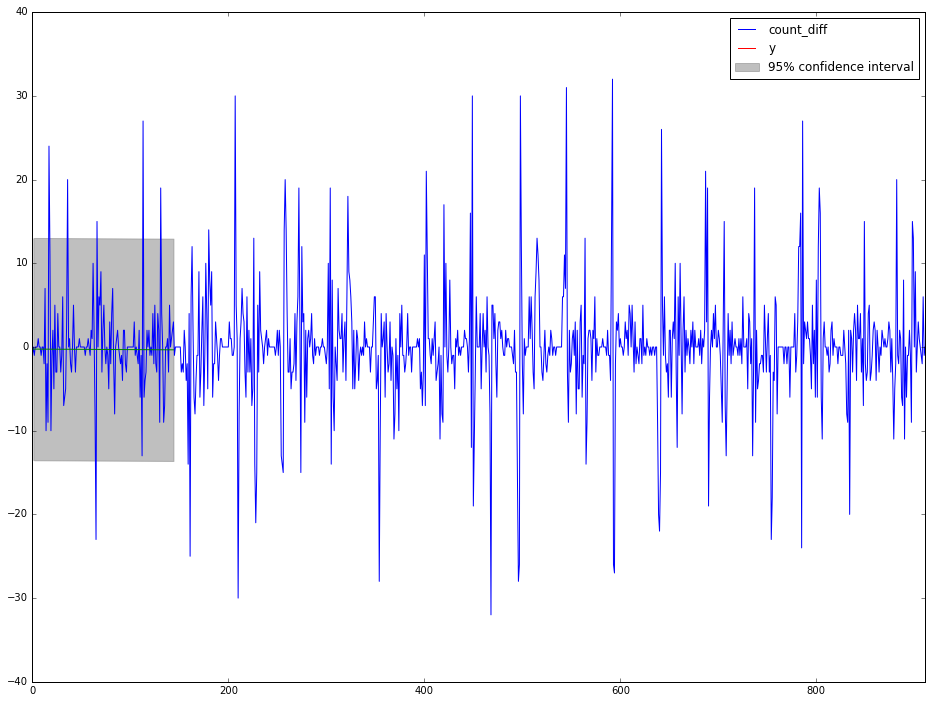

In [104]:
fig, ax = plt.subplots(figsize=(16,12))
ax = WDseasDiffplot.plot(ax=ax)
fig = results_MA.plot_predict(start=len(results_MA.fittedvalues), end=911, ax=ax, dynamic=True)
# plt.figure()
plt.show()

In [105]:
results_MA.predict()
results_MA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  767
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -2556.996
Method:                       css-mle   S.D. of innovations              6.757
Date:                Tue, 12 Apr 2016   AIC                           5121.992
Time:                        17:35:27   BIC                           5140.562
Sample:                             1   HQIC                          5129.140
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0006      0.001     -0.495      0.621        -0.003     0.002
ma.L1.D.y     -0.9251      0.038    -24.581      0.000        -0.999    -0.851
ma.L2.D.y     -0.0749      0.037     -1.998      0.046        -0.148    -0.001
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2          -13.3494           +0.0000j           13.3494            0.5000
-----------------------------------------------------------------------------
"""

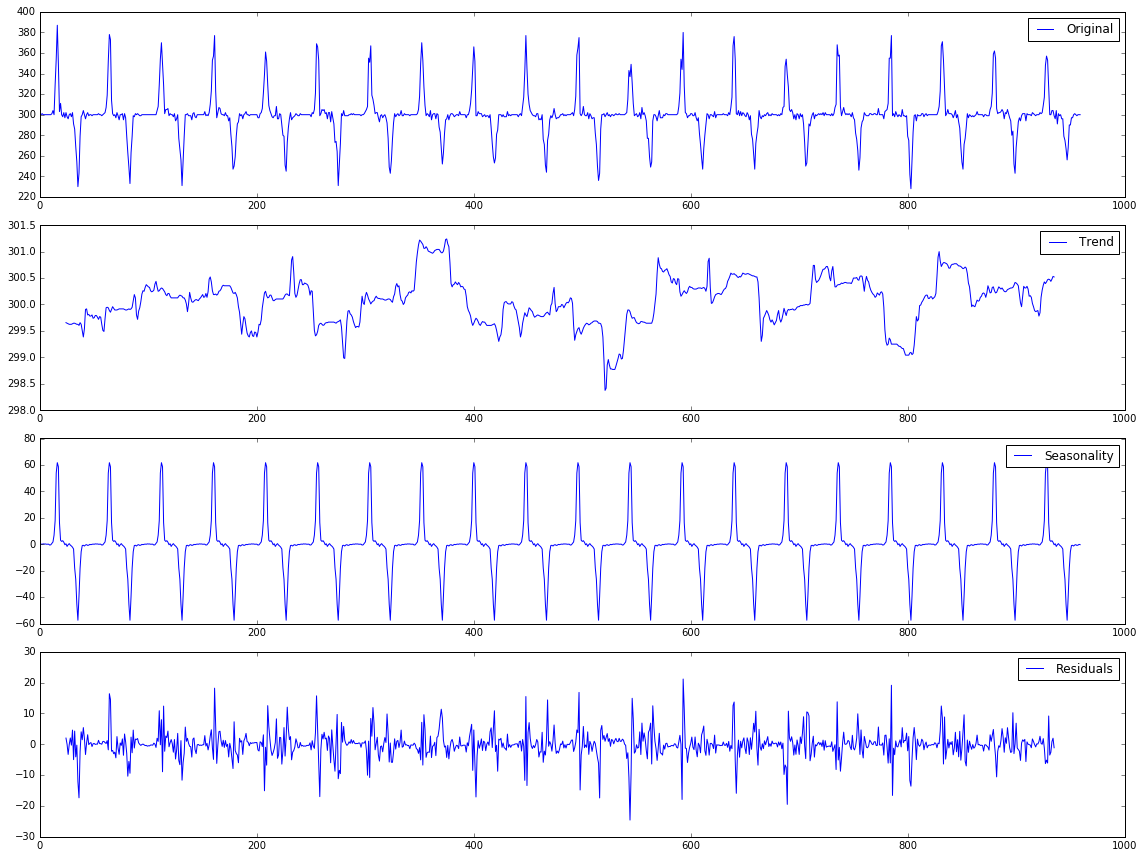

In [49]:
# Requires DateTimeIndex
decomposition = seasonal_decompose(SepModel.WD.count_diff.values, freq=48)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16,12))
plt.subplot(411)
plt.plot(SepModel.WD, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

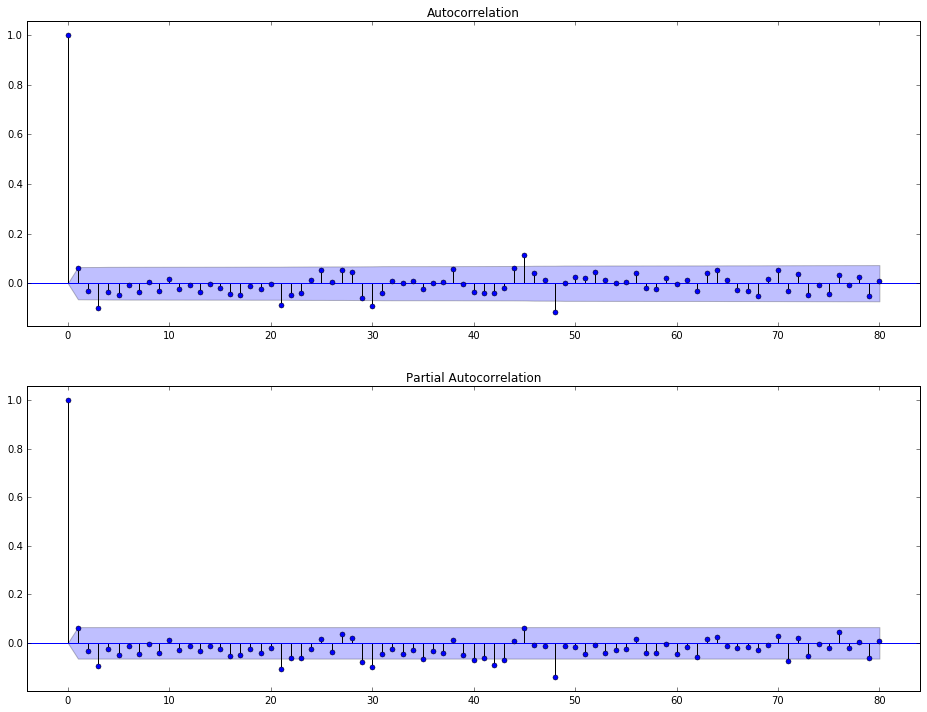

In [20]:
# lag_acf = acf(WD_decompose, nlags=80)
# lag_pacf = pacf(WD_decompose, nlags=80, method='ols')
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(211)
fig = statsmodels.graphics.tsaplots.plot_acf(WD_decompose, lags=80, ax=ax1)
ax2 = fig.add_subplot(212)
fig = statsmodels.graphics.tsaplots.plot_pacf(WD_decompose, lags=80, ax=ax2)

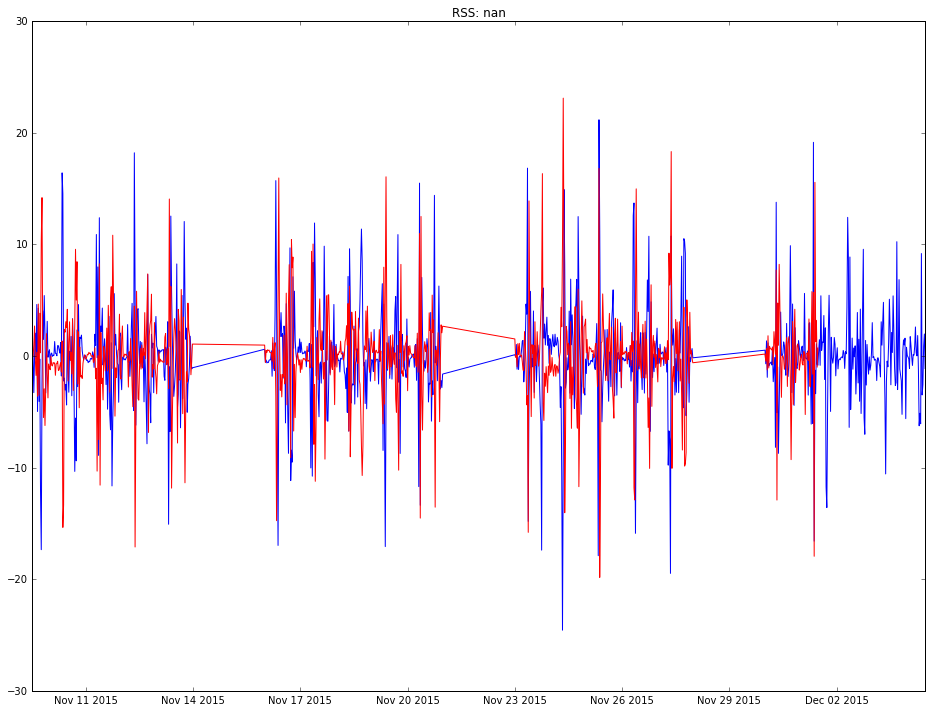

In [47]:
pred_len = 3*48
train = WD_decompose[0:len(WD_decompose)-pred_len]
test = WD_decompose[len(WD_decompose)-pred_len:len(WD_decompose)]

# Best results thus far Seasonal Decomposition->ARIMA (0,1,2) on residuals
model = ARIMA(train, order=(0, 1, 2))  
results_MA = model.fit(disp=-1) 
plt.figure(figsize=(16,12))
plt.plot(WD_decompose)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-WD_decompose.count_diff[1:])**2)) 
# Residual sum of Squares (RSS)

In [ ]:
# Creating High Resolution Figures
os.chdir(cd.wd)
a=1 # Transparency
fig = plt.figure(figsize=(16,12))
# Add a subplot
ax = fig.add_subplot(111)

# Remove grid lines (dotted lines inside plot)
ax.grid(False)
# Remove plot frame
#ax.set_frame_on(False)
# Pandas trick: remove weird dotted line on axis
#ax.lines[0].set_visible(False)

# Set x axis label on top of plot, set label text
# ax.xaxis.set_label_position('bottom')
# xlab = 'Date'
# ax.set_xlabel(xlab, fontsize=16, alpha=a, ha='left')
# ax.xaxis.set_label_coords(0, 1.04)

# Set Title
ttl = "2014 Daily Cycle Hire Usage"
#fig.suptitle(ttl, fontsize=21)
plt.title(ttl, fontsize=22, y=1.03)

# Customize y tick labels
#yticks = [0,5000,10000,15000,20000,25000,35000,40000,45000,50000]
#ax.set_yticklabels(yticks, fontsize=16, alpha=a)
#ax.yaxis.set_tick_params(pad=12)  

# Customize x tick lables
#xticks = [5,10,20,50,80]
#ax.xaxis.set_ticks(xticks)
#ax.set_xticklabels(fontsize=16, alpha=a)
 

#DailyUsage['2014'].plot(figsize=(12,8), legend=False, ax=ax, title=ttl)
plt.plot(DailyUsage['2014'])

# Save figure in png with tight bounding box
plt.savefig('test_fig.png', bbox_inches='tight', dpi=300)

In [ ]:
# Plot distribution of journey duration
november.df.Duration = november.df.Duration.astype(int)
colors = sns.set_palette("Reds")
sns.set(rc={"figure.figsize": (12, 8)})
durations = november.df.Duration[november.df.Duration <= 10000] # 10000s or 167mins
sns.distplot(durations)